In [28]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import *
import time

In [29]:
def delta(v_t_fire):
    if v_t_fire == 1.:
        return 1
    else:
        return 0

def depressing_synapses_model(x_t, y_t, z_t, t_rec, t_in, U, dt, v_t_fire):    
    dx = z_t / t_rec - U * x_t * delta(v_t_fire) * (1/dt)
    dy = - y_t / t_in + U * x_t * delta(v_t_fire) * (1/dt)
    dz = - z_t / t_rec + y_t / t_in
    
    x_t_ = x_t + dx * dt
    y_t_ = y_t + dy * dt
    z_t_ = z_t + dz * dt
    return x_t_, y_t_, z_t_

def IF_neuron(v_t, t_mem, I_syn, I_b, dt, v_t_fire, current_time, i_th_neuron, refrac_flag, intT):
    if refrac_flag[i_th_neuron, current_time] == 1:
        v_t_ = 13.5
    else:
        dv = (- v_t + I_syn + I_b) / t_mem
        v_t_ = v_t + dv * dt
        if v_t_ >= 15.:
            for i in range(30):
                if current_time + i >= intT:
                    pass
                else:
                    refrac_flag[i_th_neuron, current_time + i] = 1
            v_t_ = 13.5
            v_t_fire[i_th_neuron, current_time + 1] = 1.
            #print("neuron fired !")
    
    return v_t_

def raster(event_times_list, **kwargs):
    """
    Creates a raster plot
    Parameters
    ----------
    event_times_list : iterable
                       a list of event time iterables
    color : string
            color of vlines
    Returns
    -------
    ax : an axis containing the raster plot
    """
    ax = plt.gca()
    for ith, trial in enumerate(event_times_list):
        plt.vlines(trial, ith + .5, ith + 1.5, **kwargs)
    plt.ylim(.5, len(event_times_list) + .5)
    return ax

In [30]:
N = 40

J_ij = np.empty((0, N))
for i in range(N):
    tmp = np.zeros((1,N))
    for j in range(N):
        if randint(10) % 10 == 1:
            tmp[0, j] = 15 * np.random.normal(1, 0.5, 1)
    J_ij = np.append(J_ij, tmp, axis = 0)

In [31]:
x = 0.5
y = 0.5
z = 1 - x - y

#mili second
t_in= 3
t_mem = 30

U = np.zeros(N)
for i in range(N):
    U[i] = np.clip(np.random.normal(loc = 0.5, scale = 0.25, size = 1), 0.1, 0.9)

I_b = np.zeros(N)
for i in range(N):
    I_b[i] = np.random.uniform(low = 14.7 - 0.4, high = 14.7 + 0.4, size = 1)

t_rec = np.zeros(N)
for i in range(N):
    t_rec[i] = np.clip(np.random.normal(loc = 800, scale = 400, size = 1), 5, None)

dt = 0.1

Total = 10000
T = Total * (1/dt)
intT = int(T)

times = np.zeros(intT)

v_t = np.zeros((N, intT))
v_t_fire = np.zeros((N, intT))
refrac_flag = np.zeros((N, intT))
x_t = np.zeros((intT, N, N))
y_t = np.zeros((intT, N, N))
z_t = np.zeros((intT, N, N,))

# for debugging
I_syn = np.zeros(intT)

v_t[:,0] = 14.
x_t[0, :, :] = x
y_t[0, :, :] = y
z_t[0, :, :] = z

start = time.time()

for t in range(intT - 1):
    # this is i * dt mili second
    times[t+1] = t * dt

    if t % 1000 == 0:
        print("this is time {} sec/{} --- {} from previous stamp".format(t * dt, Total, time.time() - start))
        start = time.time()
    for i in range(N):
        # calculate the variable of i_th neuron
        I_syn_i = 0.
        #if (t +1) % 10 == 0:
        #    I_b[i] = np.random.uniform(low = 14.7 - 0.4, high = 14.7 + 0.4, size = 1)
        for j in range(N):
            # j_th synapse of i_th neuron
            # calculate I_syn = sum_of J_ij * e_t_ij
            if j == i:
                pass
            else:
                #if i == 0:
                #    print("{} I_syn_{}".format(A_ij[j, i] * e_t[t, j, i], i))
                #    print("{} e_{}".format(e_t[t, :, :],t))
                #    print("{} r_t[t, i, j], {} e_t[t, i, j], {} ina_t[t, i, j], {} u_t[t, i, j]".format(r_t[t, i, j], e_t[t, i, j], ina_t[t, i, j], u_t[t, i, j]))
                x_t[t+1, i, j], y_t[t+1, i, j], z_t[t+1, i, j] = depressing_synapses_model(x_t[t, i, j], y_t[t, i, j], z_t[t, i, j],t_rec[i], t_in, U[i], dt, v_t_fire[i, t])
            I_syn_i += J_ij[j, i] * y_t[t, j, i]
        #if i == 0:
        #    print("{} I_syn_i total".format(I_syn_i))
        v_t[i, t+1] = IF_neuron(v_t[i, t], t_mem, I_syn_i, I_b[i], dt, v_t_fire, t, i, refrac_flag, intT)  
    if t == intT - 2:
        print("this is time {}\ndone !".format((t + 2)* dt))

this is time 0.0 sec/10000 --- 0.0004200935363769531 from previous stamp
this is time 100.0 sec/10000 --- 12.913100242614746 from previous stamp
this is time 200.0 sec/10000 --- 12.389912128448486 from previous stamp
this is time 300.0 sec/10000 --- 11.39566707611084 from previous stamp
this is time 400.0 sec/10000 --- 14.976786375045776 from previous stamp
this is time 500.0 sec/10000 --- 12.606530904769897 from previous stamp
this is time 600.0 sec/10000 --- 11.426085948944092 from previous stamp
this is time 700.0 sec/10000 --- 11.818969964981079 from previous stamp
this is time 800.0 sec/10000 --- 13.236212968826294 from previous stamp
this is time 900.0 sec/10000 --- 12.11861276626587 from previous stamp
this is time 1000.0 sec/10000 --- 11.496447086334229 from previous stamp
this is time 1100.0 sec/10000 --- 11.345548152923584 from previous stamp
this is time 1200.0 sec/10000 --- 13.731104135513306 from previous stamp
this is time 1300.0 sec/10000 --- 12.106267213821411 from prev

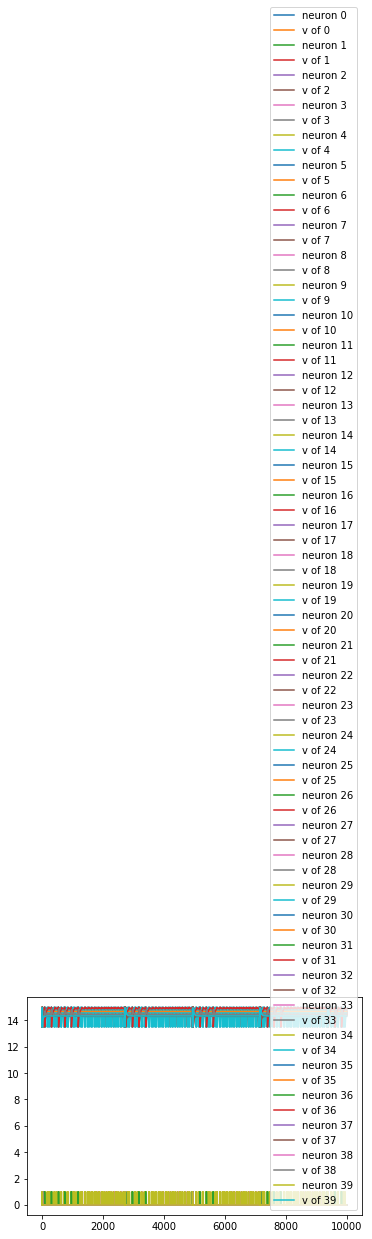

In [32]:
for i in range(N):
    plt.plot(times, v_t_fire[i, :], label='neuron {}'.format(i))
    plt.plot(times, v_t[i, :], label='v of {}'.format(i))

plt.legend(loc="lower right")

In [33]:
spikes = []

for j in range(N):
    spike = []
    for i in range(intT):
        if v_t_fire[j,i] == 1:
            spike.append(i)
            #print("{}th neuron fired spike appended".format(j))
    spikes.append(spike)
            
fig = plt.figure(figsize = (40, 10), dpi = 600)
ax = raster(spikes)
plt.title('small network raster plot')
plt.xlabel('time [sec]')
plt.ylabel('neuron')
fig.show()
plt.savefig("small network raster plot.png")

/Users/soliton/.pyenv/versions/anaconda3-4.2.0/envs/dynamicsenv/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


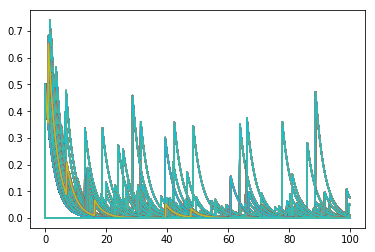

In [20]:
for j in range(N):
    for i in range(N):
        plt.plot(times[:1000], y_t[:1000, j, i], label='y')

In [12]:
for i in range(intT):
    if refrac_flag[0, i] == 1:
        print("{} fired / {} refrac period".format(v_t_fire[0, i], i))
    if v_t_fire[0, i] == 1:
        print("0th neuron fired at time {}".format(i))

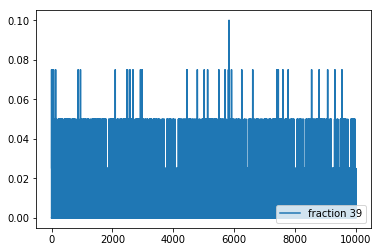

In [21]:
fractions = np.zeros(intT)

for t in range(intT):
    times[t] = t *dt
    fraction = 0
    for i in range(N):
        if v_t_fire[i, t] == 1:
            fraction +=1
    fraction = fraction / N
    #print(fraction)
    fractions[t] = fraction

plt.plot(times, fractions, label='fraction {}'.format(i))

plt.legend(loc="lower right")

In [25]:
I_b

array([15.04154144, 14.74563887, 14.77444825, 14.43656472, 14.45085272,
       14.9877536 , 14.40776569, 14.44740547, 14.51637303, 15.03359812,
       14.33847366, 15.02328913, 14.6282655 , 14.56220121, 15.0983881 ,
       14.30757866, 14.91071542, 14.68244203, 14.98798572, 14.89971671,
       15.0873302 , 14.67606987, 14.32586367, 14.94887106, 14.9534528 ,
       14.67209437, 14.90514729, 14.84941623, 14.77701977, 14.92151764,
       14.77122553, 14.94790125, 14.44236665, 14.54454194, 14.31070552,
       14.83114129, 14.46358052, 14.8133985 , 14.53872091, 14.48738239])

In [ ]:
I_b = np.zeros(N)
for i in range(N):
    I_b[i] = np.random.uniform(low = 14.7 - 0.4, high = 14.7 + 0.4, size = 1)
I_b[i] = np.random.normal(loc = 14.7 - 0.4, scale = 14.7 + 0.4, size = 1)

In [26]:
for i in range(N):
    print(J_ij[i, :])

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          6.74598743  0.         13.63550809
  0.          0.         12.40519737  0.          0.          0.
  0.          0.          0.          0.        ]
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          4.92071224  6.54946819  0.
  0.          0.          0.          0.          0.          0.
 14.04504507  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          7.2927179   0.          0.
 21.30744102  0.          0.          0.        ]
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.       

In [45]:
t_rec

array([0.70354859, 0.94776132, 0.48069593, 0.7888447 , 0.76078196,
       0.9888614 , 0.89997696, 0.61523396, 0.79658153, 0.81668418,
       0.89638997, 0.84247271, 0.8888932 , 0.96659922, 0.66334897,
       0.85520329, 0.77425922, 0.7673969 , 0.88074242, 0.89453638,
       0.89875893, 0.81897603, 0.62828992, 1.08251075, 0.89099404,
       1.06693997, 0.82428675, 0.84779273, 0.79610775, 0.75077073,
       0.70184369, 0.92559554, 0.84337522, 0.67839918, 0.69778272,
       0.91749687, 0.93021359, 0.68116037, 0.98285426, 0.77349677])